# Setup

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(100)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

path = r"../../../data/raw/formula-1-world-championship-1950-2020/versions/24/"

## Reader Files

### Datasets

### Uitleg
Ik heb deze dataset gekozen, omdat het Formule 1 seizoen weer vol op van start is gegaan en daarom bezig wou zijn met het voorspellen van rondetijden

### Beschrijving
In deze datasets staan de gegevens van alle gereden circuits, kwalificaties, vrije trainingen, sprintraces en sprint kwallificaties. Daarnaast staan ook alle gegevens van alle coureurs, constructeurs en circuits in de datasets. Ook staan de statusen die behoren bij resultaten erin.

<h3>Circuit</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>CircuitId</td><td>Id om circuit te identificeren</td><td>—</td></tr>
    <tr><td>CircuitRef</td><td>Naam van circuit in lowercase</td><td>—</td></tr>
    <tr><td>Name</td><td>Naam van circuit</td><td>—</td></tr>
    <tr><td>Location</td><td>Stad waar circuit staat</td><td>—</td></tr>
    <tr><td>Country</td><td>Land waar circuit staat</td><td>—</td></tr>
    <tr><td>Lat</td><td>Lattitude</td><td>—</td></tr>
    <tr><td>Lng</td><td>Longtitude</td><td>—</td></tr>
    <tr><td>Alt</td><td>Altitude</td><td>—</td></tr>
    <tr><td>Url</td><td>URL naar info circuit</td><td>—</td></tr>
  </tbody>
</table>

<h3>Constructor results</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>ConstructorResultId</td><td>Id om constructeurs resultaat te identificeren</td><td>—</td></tr>
    <tr><td>RaceId</td><td>Id om het resultaat naar te identificeren met de juiste race</td><td>—</td></tr>
    <tr><td>ConstructorId</td><td>Id om de constructeur te koppelen aan het resultaat</td><td>—</td></tr>
    <tr><td>Points</td><td>Het aantal gewonnen punten</td><td>regression</td></tr>
    <tr><td>Status</td><td>Id dat verwijst naar de status</td><td>classification</td></tr>
  </tbody>
</table>

<h3>Constructor standings</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>ConstructorstandingsId</td><td>Id om de constructeurs positie te identificeren</td><td>—</td></tr>
    <tr><td>RaceId</td><td>Id om het resultaat naar te identificeren met de juiste race</td><td>—</td></tr>
    <tr><td>constructorId</td><td>Id om de constructeur te koppelen aan het resultaat</td><td>—</td></tr>
    <tr><td>points</td><td>Het aantal gewonnen punten</td><td>regression</td></tr>
    <tr><td>position</td><td>De plek waar de constructeur is geëindigd</td><td>classification</td></tr>
    <tr><td>positionText</td><td>De plek waar de constructeur is geëindigd in tekst</td><td>classification</td></tr>
    <tr><td>wins</td><td>Het aantal wins dat seizoen (tot nu toe)</td><td>regression</td></tr>
  </tbody>
</table>

<h3>Constructors</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>constructorId</td><td>Id om de constructeur te identificeren</td><td>—</td></tr>
    <tr><td>constructorRef</td><td>Naam constructeur in lowercase</td><td>—</td></tr>
    <tr><td>name</td><td>Naam constructeur</td><td>—</td></tr>
    <tr><td>nationality</td><td>Afkomst constructeur</td><td>—</td></tr>
    <tr><td>url</td><td>Url voor informatie</td><td>—</td></tr>
  </tbody>
</table>

<h3>Drivers Standings</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>driverStandingsId</td><td>Id om de coureurspositie te identificeren</td><td>—</td></tr>
    <tr><td>raceId</td><td>Id om het resultaat naar te identificeren met de juiste race</td><td>—</td></tr>
    <tr><td>driverId</td><td>Id om het resultaat aan de juiste driver te koppelen</td><td>—</td></tr>
    <tr><td>points</td><td>Aantal gewonnen punten</td><td>regression</td></tr>
    <tr><td>position</td><td>Positie in het kampioensschap</td><td>classification</td></tr>
    <tr><td>positionText</td><td>Positie in het kampioensschap in tekst</td><td>classification</td></tr>
    <tr><td>wins</td><td>Aantal gewonnen races</td><td>regression</td></tr>
  </tbody>
</table>

<h3>Drivers</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>driverId</td><td>Id om de coureur te identificeren</td><td>—</td></tr>
    <tr><td>driverRef</td><td>Naam coureur lowercase</td><td>—</td></tr>
    <tr><td>number</td><td>Coureurs nummer</td><td>—</td></tr>
    <tr><td>code</td><td>Coureurs code</td><td>—</td></tr>
    <tr><td>forename</td><td>Voornaam coureur</td><td>—</td></tr>
    <tr><td>surname</td><td>Achternaam coureur</td><td>—</td></tr>
    <tr><td>dob</td><td>Geboorte datum coureur</td><td>—</td></tr>
    <tr><td>nationality</td><td>Nationaliteit coureur</td><td>—</td></tr>
    <tr><td>url</td><td>Informatie over coureur</td><td>—</td></tr>
  </tbody>
</table>

<h3>Lap times</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>raceId</td><td>Id om de tijd te koppelen aan de desbetreffende race</td><td>—</td></tr>
    <tr><td>driverId</td><td>Id om de tijd te koppelen aan de desbetreffende coureur</td><td>—</td></tr>
    <tr><td>lap</td><td>In welke ronde de tijd was neergezet</td><td>—</td></tr>
    <tr><td>position</td><td>De plek waar de coureur op dat moment stond in de race</td><td>classification</td></tr>
    <tr><td>time</td><td>De tijd van de ronde</td><td>regression</td></tr>
    <tr><td>milliseconds</td><td>De tijd van de ronde in millisecondes</td><td>regression</td></tr>
  </tbody>
</table>

<h3>Pit stops</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>raceId</td><td>Id om de pitstop te koppelen aan de race</td><td>—</td></tr>
    <tr><td>driverId</td><td>Id om de pitstop te koppelen aan de coureur</td><td>—</td></tr>
    <tr><td>stop</td><td>De hoeveelste stop het was in de race</td><td>—</td></tr>
    <tr><td>lap</td><td>De ronde waarin de pitstop werd uitgevoerd</td><td>—</td></tr>
    <tr><td>time</td><td>De tijd wanneer de pitstop is uitgevoerd</td><td>—</td></tr>
    <tr><td>duration</td><td>De tijd hoelang de pitstop duurde</td><td>regression</td></tr>
    <tr><td>milliseconds</td><td>De tijd hoelang de pitstop duurde in millisecondes</td><td>regression</td></tr>
  </tbody>
</table>

<h3>Qualifying</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>qualifyId</td><td>Id om de kwalificatie te identificeren</td><td>—</td></tr>
    <tr><td>raceId</td><td>Id om de desbetreffende race te koppelen aan de kwalificatie</td><td>—</td></tr>
    <tr><td>driverId</td><td>Id om de desbetreffende coureur aan de kwalificatie te koppelen</td><td>—</td></tr>
    <tr><td>constructorId</td><td>Id om de constructeur te koppelen aan de kwalificatie</td><td>—</td></tr>
    <tr><td>number</td><td>Nummer van coureur</td><td>—</td></tr>
    <tr><td>position</td><td>Geëindigde kwalificatie positie</td><td>classification</td></tr>
    <tr><td>q1</td><td>Beste tijd in Q1</td><td>regression</td></tr>
    <tr><td>q2</td><td>Beste tijd in Q2</td><td>regression</td></tr>
    <tr><td>q3</td><td>Beste tijd in Q3</td><td>regression</td></tr>
  </tbody>
</table>

<h3>Races</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>raceId</td><td>Id om de race te identificeren</td><td>—</td></tr>
    <tr><td>year</td><td>Het jaar dat er is geraced</td><td>—</td></tr>
    <tr><td>round</td><td>De ronde op de kalender</td><td>—</td></tr>
    <tr><td>circuitId</td><td>Id om de race te koppelen aan het desbetreffende circuit</td><td>—</td></tr>
    <tr><td>name</td><td>De circuit naam</td><td>—</td></tr>
    <tr><td>date</td><td>De datum</td><td>—</td></tr>
    <tr><td>time</td><td>De tijd van start race</td><td>—</td></tr>
    <tr><td>url</td><td>URL voor informatie</td><td>—</td></tr>
  </tbody>
</table>

<h3>Results & Sprint results</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>resultId</td><td>Id om het resultaat te identificeren</td><td>—</td></tr>
    <tr><td>raceId</td><td>Id om het resultaat te koppelen aan de desbetreffende race</td><td>—</td></tr>
    <tr><td>driverId</td><td>Id om het resultaat te koppelen aan de desbetreffende coureur</td><td>—</td></tr>
    <tr><td>constructorId</td><td>Id om het resultaat te koppelen aan de desbetreffende constructeur</td><td>—</td></tr>
    <tr><td>number</td><td>Coureurs nummer</td><td>—</td></tr>
    <tr><td>grid</td><td>Startplek op de grid</td><td>—</td></tr>
    <tr><td>position</td><td>Start positie</td><td>classification</td></tr>
    <tr><td>positionText</td><td>Start positie Tekst</td><td>classification</td></tr>
    <tr><td>positionOrder</td><td>Start positie geordend</td><td>classification</td></tr>
    <tr><td>points</td><td>Aantal punten behaald</td><td>regression</td></tr>
    <tr><td>laps</td><td>Aantal rondes gereden</td><td>regression</td></tr>
    <tr><td>time</td><td>Tijd gedaan over de race</td><td>regression</td></tr>
    <tr><td>milliseconds</td><td>Tijd gedaan over de race in millisecondes</td><td>regression</td></tr>
    <tr><td>fastestLap</td><td>Wanneer de snelste ronde is gezet door de coureur</td><td>regression</td></tr>
    <tr><td>rank</td><td>Eindpositie</td><td>classification</td></tr>
    <tr><td>fastestLapTime</td><td>Snelste ronde van coureur</td><td>regression</td></tr>
    <tr><td>fastestLapSpeed</td><td>Snelste ronde gemiddelde snelheid van coureur</td><td>regression</td></tr>
    <tr><td>statusId</td><td>Id om het resultaat te koppelen aan de desbetreffende status</td><td>classification</td></tr>
    </tbody>
</table> 
<h3>Seasons</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>year</td><td>Jaar van het seizoen</td><td>—</td></tr>
    <tr><td>url</td><td>Informatie over het seizoen</td><td>—</td></tr>
  </tbody>
</table>

<h3>Status</h3>
<table border="1">
  <thead>
    <tr><th>Kolom</th><th>Beschrijving</th><th>Type</th></tr>
  </thead>
  <tbody>
    <tr><td>statusId</td><td>Id om de status te identificeren</td><td>—</td></tr>
    <tr><td>status</td><td>Inhoud van de statuscode</td><td>Regression</td></tr>
  </tbody>
</table>


### Uiteindelijke Dataset
Na kollomen uitgefilterd te hebben heb ik dit overgehouden voor het trainen van mijn modellen
<table border="1">
  <thead>
    <tr><th>Kolomnaam</th><th>Reden</th></tr>
  </thead>
  <tbody>
    <tr><td>code</td><td>Code om de coureur te achterhalen</td></tr>
    <tr><td>number</td><td>Nummer van de coureur, zodat als er coureurs zijn met dezelfde code (Zoals Michale Schumacher en Mick Schumacher) kan je ze uit elkaar houden door hun nummer</td></tr>
    <tr><td>q1</td><td>Snelste tijd van q1</td></tr>
    <tr><td>q2</td><td>Snelste tijd van q2</td></tr>
    <tr><td>q3</td><td>Snelste tijd van q3, uiteindelijk worden alle 3 de kwalificatie tijden het gemiddelde genomen</td></tr>
    <tr><td>fastestLapTime</td><td>Snelste tijd neergezet gehele weekend</td></tr>
    <tr><td>circuit</td><td>Om te bepalen welk circuit je wilt voorspellen voor de snelste ronde</td></tr>
  </tbody>
</table>



In [2]:
def create_dataframes_csv(path):
    frame = pd.read_csv(path)
    
    return frame

In [3]:
def prefix_columns(df, table_name, exclude=None):
    if exclude is None:
        exclude = []
    return df.rename(columns={
        col: f"{table_name}__{col}" if col not in exclude else col
        for col in df.columns
    })

drivers = prefix_columns(create_dataframes_csv(f"{path}drivers.csv"), "drivers")
constructors = prefix_columns(create_dataframes_csv(f"{path}constructors.csv"), "constructors")
constructor_standings = prefix_columns(create_dataframes_csv(f"{path}constructor_standings.csv"), "constructor_standings")
qualifying = prefix_columns(create_dataframes_csv(f"{path}qualifying.csv"), "qualifying")
circuits = prefix_columns(create_dataframes_csv(f"{path}circuits.csv"), "circuits")
results = prefix_columns(create_dataframes_csv(f"{path}results.csv"), "results")
pit_stops = prefix_columns(create_dataframes_csv(f"{path}pit_stops.csv"), "pit_stops")
races = prefix_columns(create_dataframes_csv(f"{path}races.csv"), "races")

drivers = drivers.drop(columns=[
    "drivers__url", "drivers__dob"
])

constructors = constructors.drop(columns=[
    "constructors__url"
])

constructor_standings = constructor_standings.drop(columns=[
    "constructor_standings__positionText"
])

circuits = circuits.drop(columns=[
    "circuits__url", "circuits__alt", "circuits__lng", "circuits__lng"
])

results = results.drop(columns=[
    "results__positionText"
])

races = races.drop(columns=[
    "races__url"
])

total = pd.merge(drivers, results, left_on="drivers__driverId", right_on="results__driverId")
total = pd.merge(total, races, left_on="results__raceId", right_on="races__raceId")
total = pd.merge(total, circuits, left_on="races__circuitId", right_on="circuits__circuitId")
total = pd.merge(total, qualifying, left_on=["races__raceId", "drivers__driverId"], right_on=["qualifying__raceId", "qualifying__driverId"])
total = pd.merge(total, pit_stops, left_on=["qualifying__raceId", "qualifying__driverId"], right_on=["pit_stops__raceId", "pit_stops__driverId"])
total = pd.merge(total, constructors, left_on="qualifying__constructorId", right_on="constructors__constructorId")
total = pd.merge(total, constructor_standings, left_on="constructors__constructorId", right_on="constructor_standings__constructorId")

total = total.drop(columns=[
    "drivers__driverId",
    "results__driverId", "results__raceId", "results__constructorId", "results__statusId", "results__number", "results__driverId",
    "races__raceId", "races__circuitId",
    "circuits__circuitId",
    "qualifying__qualifyId", "qualifying__raceId", "qualifying__driverId", "qualifying__constructorId", "qualifying__number",
    "pit_stops__driverId",
    "constructors__constructorId",
    "constructor_standings__constructorStandingsId", "constructor_standings__raceId", "constructor_standings__constructorId"
])

total = total.drop_duplicates()

total


,drivers__driverRef,drivers__number,drivers__code,drivers__forename,drivers__surname,drivers__nationality,results__resultId,results__grid,results__position,results__positionOrder,...,pit_stops__lap,pit_stops__time,pit_stops__duration,pit_stops__milliseconds,constructors__constructorRef,constructors__name,constructors__nationality,constructor_standings__points,constructor_standings__position,constructor_standings__wins
0,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,14.0,1,1
1,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,24.0,1,1
2,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,28.0,3,1
3,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,34.0,3,1
4,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,42.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020547,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,14.0,9,0
5020548,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,49.0,6,0
5020549,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,49.0,7,0
5020550,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,59.0,6,0


In [4]:
print(total.columns)

Index(['drivers__driverRef', 'drivers__number', 'drivers__code',
       'drivers__forename', 'drivers__surname', 'drivers__nationality',
       'results__resultId', 'results__grid', 'results__position',
       'results__positionOrder', 'results__points', 'results__laps',
       'results__time', 'results__milliseconds', 'results__fastestLap',
       'results__rank', 'results__fastestLapTime', 'results__fastestLapSpeed',
       'races__year', 'races__round', 'races__name', 'races__date',
       'races__time', 'races__fp1_date', 'races__fp1_time', 'races__fp2_date',
       'races__fp2_time', 'races__fp3_date', 'races__fp3_time',
       'races__quali_date', 'races__quali_time', 'races__sprint_date',
       'races__sprint_time', 'circuits__circuitRef', 'circuits__name',
       'circuits__location', 'circuits__country', 'circuits__lat',
       'qualifying__position', 'qualifying__q1', 'qualifying__q2',
       'qualifying__q3', 'pit_stops__raceId', 'pit_stops__stop',
       'pit_stops__lap', 

# Fastest lap prediction

### Dataset

In [7]:
def time_to_seconds(t):
    try:
        if t == "0:00.000" or pd.isna(t):
            return 0.0
        mins, rest = t.split(":")
        return int(mins) * 60 + float(rest)
    except:
        return 0.0

circuit = input(str("Circuit: "))

fastes_lap_data = pd.DataFrame()

fastes_lap_data = total[["drivers__code", "drivers__number", 
                         "circuits__name",
                         "qualifying__q1", "qualifying__q2", "qualifying__q3",
                         "results__fastestLapTime",]]

fastes_lap_data = fastes_lap_data.drop_duplicates()

for index, row in fastes_lap_data.iterrows():
    if (str(row["circuits__name"]).lower() != circuit.lower()):
        fastes_lap_data.drop(index, inplace=True)

fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]] = \
    fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]].fillna("0:00.000")

for col in ["qualifying__q1", "qualifying__q2", "qualifying__q3"]:
    fastes_lap_data[col] = fastes_lap_data[col].apply(time_to_seconds)

meta = fastes_lap_data[["drivers__code", "drivers__number", "circuits__name"]].reset_index(drop=True)

X_full = pd.concat([fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]],
                    pd.get_dummies(fastes_lap_data[["drivers__code", "drivers__number", 
                                                    "circuits__name"]], drop_first=True)],
                   axis=1)

fastes_lap_data["fastestLapSeconds"] = fastes_lap_data["results__fastestLapTime"].apply(time_to_seconds)
y_full = fastes_lap_data["fastestLapSeconds"]


In [8]:
fastes_lap_data

,drivers__code,drivers__number,circuits__name,qualifying__q1,qualifying__q2,qualifying__q3,results__fastestLapTime,fastestLapSeconds
102853,HAM,44,Red Bull Ring,69.514,69.092,0.000,1:12.217,72.217
115358,HAM,44,Red Bull Ring,72.218,69.062,68.455,1:11.475,71.475
127253,HAM,44,Red Bull Ring,66.947,66.228,67.922,1:08.411,68.411
140978,HAM,44,Red Bull Ring,65.064,64.800,64.424,1:07.411,67.411
149823,HAM,44,Red Bull Ring,64.080,63.577,63.149,1:07.241,67.241
...,...,...,...,...,...,...,...,...
4868528,DEV,21,Red Bull Ring,65.974,0.000,0.000,1:09.852,69.852
4880091,PIA,81,Red Bull Ring,65.683,65.605,0.000,1:09.862,69.862
4924683,PIA,81,Red Bull Ring,65.311,65.070,65.048,1:08.697,68.697
4961548,SAR,2,Red Bull Ring,65.948,0.000,0.000,1:09.611,69.611


## Trainen

In [9]:
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_full, y_full, meta, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 0.8754904065040647


In [13]:
results_df = pd.DataFrame({
    "Driver": meta_test["drivers__code"].values,
    "Number": meta_test["drivers__number"].values,
    "Circuit": meta_test["circuits__name"].values,
    "Predicted (s)": y_pred,
    "Actual (s)": y_test.values
})

results_df = results_df.sort_values(by=["Actual (s)"])

results_df


,Driver,Number,Circuit,Predicted (s),Actual (s)
60,SAI,55,Red Bull Ring,67.09654,65.619
10,VET,5,Red Bull Ring,68.09491,67.082
53,PER,11,Red Bull Ring,68.78835,67.188
104,VER,33,Red Bull Ring,68.85352,67.275
93,RIC,3,Red Bull Ring,69.18840,67.442
...,...,...,...,...,...
90,VET,5,Red Bull Ring,72.36279,74.254
92,KVY,26,Red Bull Ring,72.63511,74.332
12,BIA,17,Red Bull Ring,73.76478,74.476
83,ERI,9,Red Bull Ring,73.75351,74.672


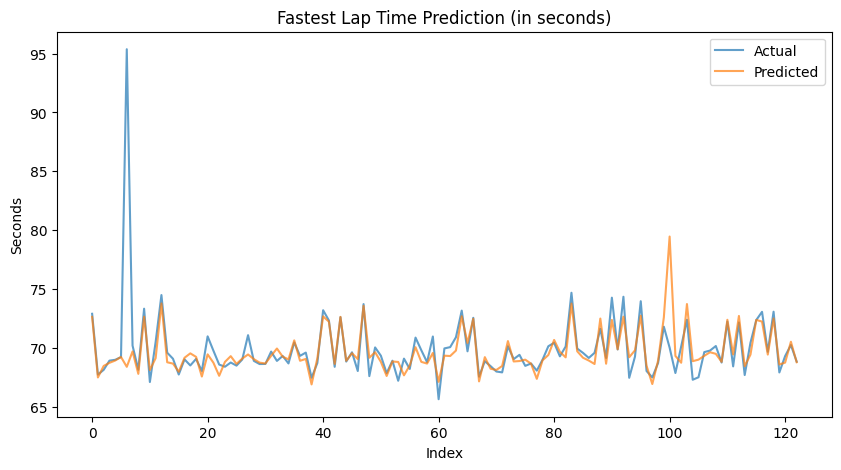

In [14]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Fastest Lap Time Prediction (in seconds)")
plt.ylabel("Seconds")
plt.xlabel("Index")
plt.legend()
plt.show()


## Decision Tree

Regressor wordt gebruikt i.p.v. Class, omdat er gewerkt wordt met float nummers, inplaats van normale nummers

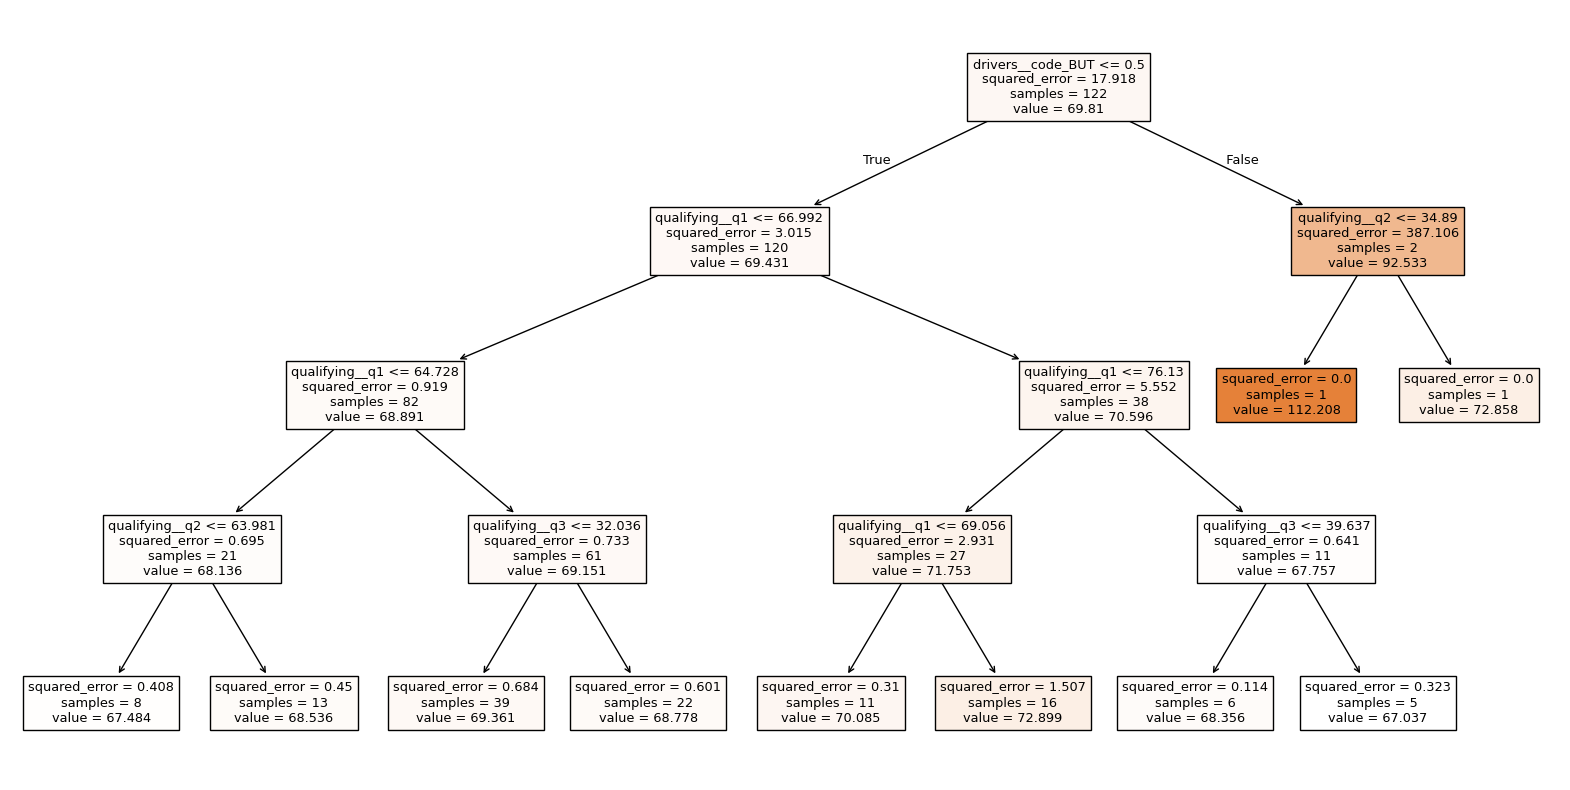

In [15]:
dtree = DecisionTreeRegressor(max_depth=4, random_state=42)
dtree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=X_train.columns, filled=True)
plt.show()


## Confusion Matrix

In [16]:
def predict(X_test, y_test, predict_column_name, y_column_name):
    predicted_df = pd.DataFrame(dtree.predict(X_test), columns=[predict_column_name])
    actual_df = y_test.reset_index(drop=True).to_frame(name=y_column_name)
    return pd.concat([actual_df, predicted_df], axis=1)


In [17]:
model_results_frame = predict(X_test, y_test, "Predicted (s)", "Actual (s)")
model_results_frame

,Actual (s),Predicted (s)
0,72.884,72.899000
1,67.712,67.484500
2,68.117,68.536462
3,68.900,68.778318
4,68.971,69.361128
...,...,...
118,73.060,72.899000
119,67.894,68.536462
120,69.288,69.361128
121,70.228,70.085091


In [18]:
actual = []
predicted = []

for x in model_results_frame["Actual (s)"]:
    actual.append(int(x))
    
for x in model_results_frame["Predicted (s)"]:
    predicted.append(int(x))
    
print(len(actual), len(predicted))

123 123


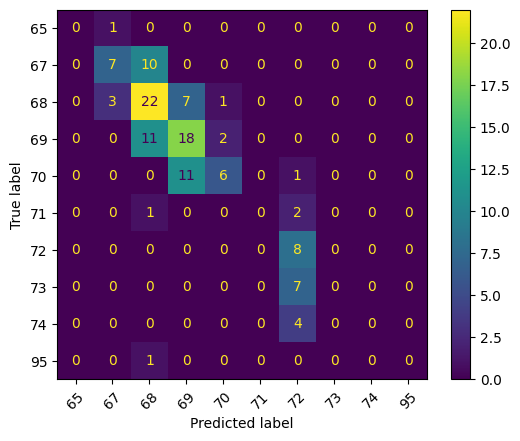

In [19]:
labels = sorted(set(actual) | set(predicted))

confusion_matrix = metrics.confusion_matrix(
    actual,
    predicted
)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
cm_display.plot()
plt.xticks(rotation=45)
plt.show()


## Neural Network Regression

In [20]:
ct = make_column_transformer(
    (MinMaxScaler(), ["qualifying__q1", "qualifying__q2", "qualifying__q3"])
)

ct.fit(X_train)
X_train_normalized = ct.transform(X_train)
X_test_normalized = ct.transform(X_test)
X_train_normalized

array([[0.82388093, 0.53000284, 0.88829787],
       [0.78514255, 0.50460186, 0.78639483],
       [0.78713446, 0.50508335, 0.79230636],
       [0.8023243 , 0.51450019, 0.80109345],
       [0.85641138, 0.54837869, 0.85791331],
       [0.8023854 , 0.51761809, 0.80300637],
       [0.80017353, 0.        , 0.        ],
       [0.80254427, 0.51455544, 0.79995804],
       [0.80728575, 0.        , 0.        ],
       [0.78495925, 0.50498074, 0.78565434],
       [0.82631277, 0.        , 0.        ],
       [0.78307732, 0.50183916, 0.77934788],
       [0.99155577, 0.6331381 , 0.        ],
       [0.79442998, 0.        , 0.        ],
       [0.95681343, 0.61519639, 0.99334798],
       [0.81397026, 0.        , 0.        ],
       [0.82036148, 0.52780058, 0.87812855],
       [0.78946854, 0.50758556, 0.        ],
       [0.81701311, 0.        , 0.        ],
       [0.80641811, 0.52004925, 0.        ],
       [0.80331415, 0.        , 0.        ],
       [0.78759883, 0.5067094 , 0.79205953],
       [0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4745 - mae: 1.4745 
[1.3205974102020264, 1.3205974102020264]


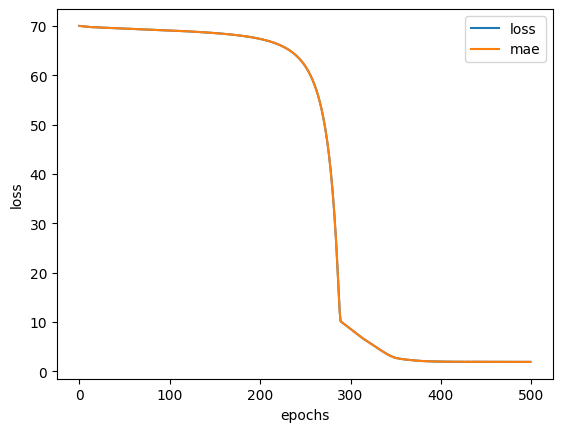

In [21]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.0015),
                metrics=["mae"]
)

history = model_1.fit(X_train_normalized, y_train, epochs=500, verbose=0)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
print(model_1.evaluate(X_test_normalized, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Length of y_predict: 123
Length of y_test: 123
123 123 123


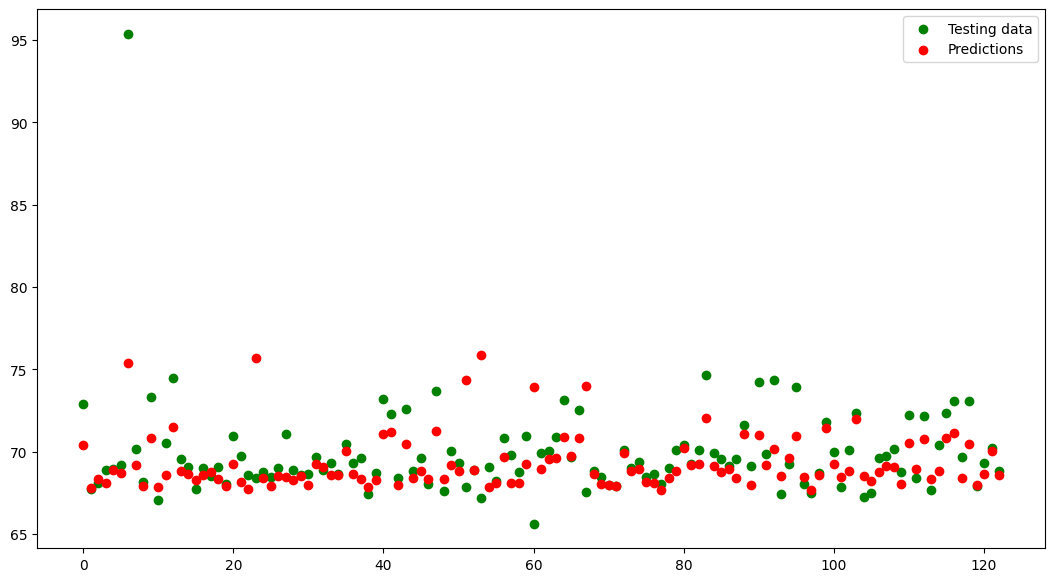

In [23]:
def plot_predictions(test_X, test_Y, pred_Y):
    plt.figure(figsize=(13, 7))
    plt.scatter(test_X, test_Y, c="g", label="Testing data")
    plt.scatter(test_X, pred_Y, c="r", label="Predictions")
    plt.legend()
    plt.show()

y_predict = model_1.predict(X_test_normalized)

y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test
y_predict = tf.squeeze(y_predict).numpy() 

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0].to_numpy() 

print(f"Length of y_predict: {len(y_predict)}")
print(f"Length of y_test: {len(y_test)}")

test_X = tf.range(0, len(y_test)).numpy()

print(len(test_X), len(y_test), len(y_predict))

plot_predictions(test_X, y_test, y_predict)
